In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.ndimage.filters import uniform_filter1d
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from scipy.stats import t as TD

In [3]:
log_pr = pd.read_pickle("/content/drive/My Drive/STATS601/log_price_drive_new.df")
volu = pd.read_pickle("/content/drive/My Drive/STATS601/volu_drive_new.df")


log_pr['timestamp'] = pd.to_datetime(log_pr['timestamp'])
log_pr.set_index('timestamp', inplace=True)

volu['timestamp'] = pd.to_datetime(volu['timestamp'])
volu.set_index('timestamp', inplace=True)

In [4]:
# moving averages of different time span
def mov_avg(A, B, window_length=60):
    # Input: two 1440 x 1 numpy arrays
    # Output: two 288 x 1 numpy arrays
    
    pr_avg = uniform_filter1d(A, size=window_length, mode='nearest')[::30]
    vo_avg = uniform_filter1d(B, size=window_length, mode='nearest')[::30]

    return pr_avg[-10:], vo_avg[-5:]

In [5]:
def MACD(A):
    # Input: 1440 x 1 DataFrame
    # Output: two 1440 x 1 numpy array
    df = np.exp(A)
        
    # Get the 26-day EMA of the closing price
    k = df.ewm(span=26, adjust=False, min_periods=26).mean()
    # Get the 12-day EMA of the closing price
    d = df.ewm(span=12, adjust=False, min_periods=12).mean()

    # Subtract the 26-day EMA from the 12-Day EMA to get the MACD
    macd = k - d

    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = np.array(macd.ewm(span=9, adjust=False, min_periods=9).mean())

    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    #macd_h = macd - macd_s
    
    return np.array(macd), macd_s #, macd_h

In [6]:
def np_ewma_vectorized(data, window, method = "WMS"):

    if method == "WMS":
        alpha = 1 / window
    elif method == "EMA":
        alpha = 2 / (window + 1.0)
    alpha_rev = 1 - alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1 / pows[:-1]
    offset = data[0] * pows[1:]
    pw0 = alpha * alpha_rev**(n-1)

    mult = data * pw0 * scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums * scale_arr[::-1]
    return out


def MACD(A):
    # Input: 1440 x 1 DataFrame
    # Output: two 1440 x 1 numpy array
    A = np.exp(A)
        
    # Get the 26-day EMA of the closing price
    k = np_ewma_vectorized(A, 26)
    # Get the 12-day EMA of the closing price
    d = np_ewma_vectorized(A, 12)

    # Subtract the 26-day EMA from the 12-Day EMA to get the MACD
    macd = k - d

    #Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = np.array(np_ewma_vectorized(macd, 9))

    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    #macd_h = macd - macd_s
    
    return k, d, np.array(macd)#, macd_s#, macd_h

In [7]:
A = log_pr.iloc[20000:21440:30,0]
k, d, macd1, macd2 = MACD(A)
plt.plot(A)
#plt.plot(k)
#plt.plot(d)

ValueError: ignored

In [8]:
plt.plot(k)
plt.plot(d)

NameError: ignored

In [9]:
def RSI_np(A, window_length=14):
    """
    Calculate RSI
    A: numpy array of log price
    method : "SMA": simple moving average,
            "WMS": Wilder Smoothing Method,
            "EMA": exponential moving average
    
    Return RSI for last three periods
    """
    # transform log-price to price
    A = np.exp(A)
    tmp = np.diff(A)

    gain = np.clip(tmp, a_min = 0, a_max = None)
    loss = np.abs(np.clip(tmp, a_min = None, a_max = 0))

    avg_gain = np_ewma_vectorized(gain, window_length, 'WMS')#[-10:]
    avg_loss = np_ewma_vectorized(loss, window_length, 'WMS')#[-10:]
    
    rsi1 = 100 - (100 * avg_loss / (avg_loss + avg_gain))
        
    avg_gain = np_ewma_vectorized(gain, window_length, 'EMA')#[-10:]
    avg_loss = np_ewma_vectorized(loss, window_length, 'EMA')#[-10:]
    
    #rs = avg_gain / avg_loss
    rsi2 = 100 - (100 * avg_loss / (avg_loss + avg_gain))
    return rsi1[-2:], rsi2[-2:]

NameError: ignored

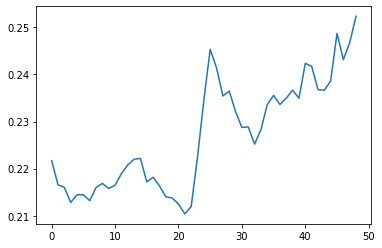

In [10]:
A = log_pr.iloc[1440*139:(1440*140+30):30,3]
#rsi = RSI_np(A)
plt.plot(A.values)
plt.plot(rsi / 1000 + 0.3)

In [11]:
plt.plot(rsi)

NameError: ignored

In [12]:
np.corrcoef((A[1:].values - A[:-1].values), rsi)


NameError: ignored

In [13]:
def volChanges(B, window_length=30):
    vol0 = np.mean(B[-30:])
    vol1 = np.mean(B[-60:-30])
    vol2 = np.mean(B[-90:-60])
    vol3 = np.mean(B[-120:-90])
    # vol4 = np.mean(B[-180:-120])
    
    return np.array([vol2-vol3, vol1-vol2, vol0-vol1, vol0])

In [14]:
def getVolRatios(vol, volWindow=[10, 30, 60]):  
    # Input: 1440 x 1 numpy array
    # the window here is in minutes
    # Output: 3 dim numpy array
    
    return np.array([sum(vol[-win:]) for win in volWindow]) / sum(vol)

In [15]:
def priceVolCor(A, B, time=[1440, 720, 360]):
    # Input: two 1440 x 1 numpy arrays
    # Output: 3 dim numpy array
    
    pv_cor = A
    temp = np.hstack((A, B))
    pv_cor = [np.corrcoef(temp[-t:]) for t in time]
    return np.array(pv_cor)

In [16]:
# z-score of log-price
def zScorePr(A):
    # Input: 1440 x 1 numpy array
    # Output: 3 dim numpy array
    # the moving average log-price of 30min, 1h, and 3h

    A = np.hstack((A[0]*np.ones(90), A, A[-1]*np.ones(90)))
    
    # moving averages of 30 minutes
    N = 15
    pr_avg_0 = np.convolve(A[(90-N):-(91-N)], np.ones(2*N)/N/2, mode='valid')
    
    # 1 hour (60 minutes)
    N = 30
    pr_avg_1 = np.convolve(A[(90-N):-(91-N)], np.ones(2*N)/N/2, mode='valid')
    
    # 2 hour (120 minutes)
    N = 60
    pr_avg_2 = np.convolve(A[(90-N):-(91-N)], np.ones(2*N)/N/2, mode='valid')
    
    # 3 hours (180 minutes)
    N = 90
    pr_avg_3 = np.convolve(A[(90-N):-(91-N)], np.ones(2*N)/N/2, mode='valid')
    
    z0 = (A[-1] - pr_avg_0[-1]) / np.std(pr_avg_0)
    z1 = (A[-1] - pr_avg_1[-1]) / np.std(pr_avg_1)
    z2 = (A[-1] - pr_avg_2[-1]) / np.std(pr_avg_2)
    z3 = (A[-1] - pr_avg_3[-1]) / np.std(pr_avg_3)
    return np.array([z0, z1, z2, z3])

In [17]:
def neg30logr(A):
    return -(A[-1] - A[-30])

In [40]:
with open('/content/drive/My Drive/STATS601/tDistr.pkl', 'rb') as f:
  paramsDict = pickle.load(f)

def getTdist(A, assetVal):
  # print(paramsDict)
  return TD.cdf(A[-1], df = paramsDict[assetVal]["df"], loc = paramsDict[assetVal]["loc"], scale = paramsDict[assetVal]["scale"])

{0: {'df': 2.5346169533055187, 'loc': -0.00027365262053218856, 'scale': 0.0032562288165270733}, 1: {'df': 2.1173732652490624, 'loc': -0.00035007191667327416, 'scale': 0.0024365638999085774}, 2: {'df': 2.382781777272213, 'loc': -0.0002686326409066102, 'scale': 0.004322769126866292}, 3: {'df': 2.9914518737683937, 'loc': -0.0002335418548962783, 'scale': 0.0029122221147063936}, 4: {'df': 3.0543768005038823, 'loc': -0.00022099798109251754, 'scale': 0.002452614134411103}, 5: {'df': 2.0939964738508885, 'loc': -0.00028816371145939837, 'scale': 0.002070045010104415}, 6: {'df': 2.716796209736719, 'loc': -0.00019714430950733188, 'scale': 0.0021338269483804494}, 7: {'df': 3.7025869690938653, 'loc': -0.00022811567109466756, 'scale': 0.0024265268827952666}, 8: {'df': 3.9645065419704677, 'loc': -2.6966740321696557e-05, 'scale': 0.0019897834536206174}, 9: {'df': 3.1785877030025707, 'loc': -1.633725109889926e-05, 'scale': 0.0017959047704221582}}


0.019413838472709184

In [41]:
def get_features(A, B, assetVal):
    m1, m2 = mov_avg(A, B)
    macd1, _, macd = MACD(A[::30])
    rsi1, rsi2 = RSI_np(A[::30])
    return np.hstack((
        m1[-2:], #m2,
        macd1[-1], #macd[-1],
        rsi1, rsi2,
        volChanges(B)[2:], # 8 9
        #getVolRatios(B),
        #priceVolCor(A, B),
        zScorePr(A)[[0,1]],
        neg30logr(A),
        getTdist(A, assetVal)
    )).reshape((1, -1))

In [42]:
f = get_features(log_pr.iloc[:1440,0], volu.iloc[:1440,0], assetVal=0)
p = np.shape(f)[1]
print(len(log_pr.iloc[0:1440,0]), f.shape)

1440 (1, 13)


In [43]:
# compute and save the feature "pool"

feature = {}
ytrain = {}
feature_test = {}

test_res = []
selected_rank2 = []

ytest = []
pred = []

for asset in range(10):
    t0 = time.time()
    
    fs = get_features(log_pr.iloc[:1440, asset], volu.iloc[:1440, asset], assetVal=asset)
    y = log_pr.iloc[1440+29, asset] - log_pr.iloc[1440-1, asset]
    #y = np.mean(log_pr.iloc[(1440+27):(1440+32), asset]) - log_pr.iloc[1440-1, asset]
    
    d = 10

    for t in range(1440*121 - 30)[d::d]: # compute the predictions every 10 minutes
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset], assetVal=asset)
        fs = np.vstack((fs, f))
        y = np.vstack((
            y, 
            log_pr.iloc[t+1440+29, asset] - log_pr.iloc[t+1440-1, asset]
        ))

    #t_used = time.time() - t0
    #print(t_used, np.shape(fs), np.shape(y))
    
    feature[asset] = fs
    ytrain[asset] = y
    
    model = LinearRegression()
    model.fit(fs, y)
    
    ftest = get_features(log_pr.iloc[1440*122:1440*123, asset], volu.iloc[1440*122:1440*123, asset], assetVal=asset)
    ytest.append(log_pr.iloc[1440*123+29, asset] - log_pr.iloc[1440*123-1, asset])
    
    d = 10

    for t in range(1440*122+10,264960-1470,d): # compute the predictions every 10 minutes
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset], assetVal=asset)
        ftest = np.vstack((ftest, f))
        ytest.append(log_pr.iloc[t+1440+29, asset] - log_pr.iloc[t+1440-1, asset])
    
    feature_test[asset] = ftest
    pred.append(model.predict(ftest))
    
    t_used = time.time() - t0
    print(t_used, np.shape(ftest), np.shape(ytest), np.shape(pred))
    
    #test_res.append(np.corrcoef(pred[:,0], ytest[:,0])[0,1])
    #with open('./model_{}.pkl'.format(asset),'wb') as f:
    #    pickle.dump(model,f)
    
    #select = RFE(model, n_features_to_select=40, step=1).fit(fs, y)
    #selected.append([i for i in range(p) if select.support_[i]])
    #selected_rank2.append(select.ranking_)

132.88662576675415 (8781, 13) (8781,) (1, 8781, 1)
135.2589099407196 (8781, 13) (17562,) (2, 8781, 1)
133.86098194122314 (8781, 13) (26343,) (3, 8781, 1)
132.97457098960876 (8781, 13) (35124,) (4, 8781, 1)
131.44459342956543 (8781, 13) (43905,) (5, 8781, 1)
131.79697966575623 (8781, 13) (52686,) (6, 8781, 1)
132.77440214157104 (8781, 13) (61467,) (7, 8781, 1)
133.36468291282654 (8781, 13) (70248,) (8, 8781, 1)
135.54861068725586 (8781, 13) (79029,) (9, 8781, 1)
133.06124687194824 (8781, 13) (87810,) (10, 8781, 1)


timestamp
2021-07-01 00:10:00    0.000808
2021-07-01 00:11:00    0.000602
2021-07-01 00:12:00   -0.000064
2021-07-01 00:13:00   -0.001349
2021-07-01 00:14:00   -0.001102
                         ...   
2021-07-02 00:05:00   -0.010813
2021-07-02 00:06:00   -0.011563
2021-07-02 00:07:00   -0.012272
2021-07-02 00:08:00   -0.011475
2021-07-02 00:09:00   -0.011153
Name: 0, Length: 1440, dtype: float64

In [44]:
a_file = open("/content/drive/My Drive/STATS601/feature_train.pkl", "wb")
pickle.dump(feature, a_file)
a_file.close()

a_file = open("/content/drive/My Drive/STATS601/feature_test.pkl", "wb")
pickle.dump(feature_test, a_file)
a_file.close()

a_file = open("/content/drive/My Drive/STATS601/y_train.pkl", "wb")
pickle.dump(ytrain, a_file)
a_file.close()

a_file = open("/content/drive/My Drive/STATS601/y_test.pkl", "wb")
pickle.dump(ytest, a_file)
a_file.close()

#a_file = open("data.pkl", "rb")
#output = pickle.load(a_file)

In [45]:
[np.corrcoef(
    np.array(pred).reshape((1,-1))[0, k*8781:(k+1)*8781],
    np.array(ytest)[k*8781:(k+1)*8781]
)[0, 1] for k in range(10)]

[0.0035762740589267124,
 0.10796076785379936,
 0.07317628360081506,
 0.027432374380966105,
 0.06569513278689827,
 0.058873932157186844,
 0.028115506451062554,
 0.03847854957463483,
 0.06105366494440309,
 0.06189555261774635]

In [46]:
feature[0].shape

(17421, 13)

In [47]:
print(np.shape(fs), np.shape(y))
np.corrcoef(np.array(pred).reshape((1,-1)), np.array(ytest))

(17421, 13) (17421, 1)


array([[1.        , 0.02674453],
       [0.02674453, 1.        ]])

In [ ]:
# 100 + dim
0.01922068
# rsi + volchange + zscore + neg 30  6 x 1
0.04946184

In [ ]:
# rsi (-1) + volchange + neg 30
0.04189984

In [ ]:
np.corrcoef(np.array(pred).reshape((1,-1)), np.array(ytest))[0,1]
# rsi (-1) + volchange (4 dim) + zscore + neg 30 log return
0.04330438

0.050721814312798395

In [48]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [194]:
# model selection with forward selection

test_res = []
selected_rank2 = []

ytest = []
pred = []

# selected features for each asset
flist = [[6,7,8,9,10,11],
         [6,7,10,12],
         [7,8,12],#8
         [7,8,9,12],#9
         [6,7,8,9,10,11],#7
         [7,8,9,10,11],
         [6,7,8,9,10,11,12],
         [6,7,8,9,11,12],
         [6,7,8,11,12],#7
         [6,7,8,9,10,11]
        ]
#flist = [[6,7,8,9,10,11] for i in range(10)]

for asset in range(10):
    t0 = time.time()
    '''
    fs = get_features(log_pr.iloc[:1440, asset], volu.iloc[:1440, asset])
    y = log_pr.iloc[1440+29, asset] - log_pr.iloc[1440-1, asset]
    #y = np.mean(log_pr.iloc[(1440+27):(1440+32), asset]) - log_pr.iloc[1440-1, asset]
    
    d = 10

    for t in range(1440*121 - 30)[d::d]: # compute the predictions every 10 minutes
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset])
        fs = np.vstack((fs, f))
        y = np.vstack((
            y, 
            log_pr.iloc[t+1440+29, asset] - log_pr.iloc[t+1440-1, asset]
        ))
    '''
    
    fs = np.array(feature[asset])
    y = np.array(ytrain[asset])
    fs[:, [7,8]] = fs[:, [7,8]] / 10**8
    fs = fs[:, flist[asset]]
    
    df = pd.DataFrame(fs, columns=['x' + str(i) for i in range(len(flist[asset]))])
    df['y'] = y
    
    #model = forward_selected(df, 'y')
    #print(model.summary())
    
    #lm = sm.OLS.from_formula('y ~ x0+x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11+x12+x13+x14+x15', data=df)
    #res = lm.fit()
    #print(res.aic)
    
    model = LinearRegression()
    model.fit(fs, y)
    
    
    #ftest = get_features(log_pr.iloc[1440*122:1440*123, asset], volu.iloc[1440*122:1440*123, asset])
    ytest.append(log_pr.iloc[1440*123+29, asset] - log_pr.iloc[1440*123-1, asset])
    
    d = 10

    for t in range(1440*122+10,264960-1470,d): # compute the predictions every 10 minutes
        #f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset])
        #ftest = np.vstack((ftest, f))
        ytest.append(log_pr.iloc[t+1440+29, asset] - log_pr.iloc[t+1440-1, asset])
    
    
    ftest = np.array(feature_test[asset])
    ytes = np.array(ytest)[asset*8781:(asset+1)*8781]
    
    ftest[:, [7,8]] = ftest[:, [7,8]] / 10**8
    ftest = ftest[:, flist[asset]]
    pred.append(model.predict(ftest))
    
    t_used = time.time() - t0
    print(t_used, np.shape(ftest), np.shape(ytest), np.shape(pred))
    
    #test_res.append(np.corrcoef(pred[:,0], ytest[:,0])[0,1])


0.5744950771331787 (8781, 6) (8781,) (1, 8781, 1)
0.5718405246734619 (8781, 4) (17562,) (2, 8781, 1)
0.5642783641815186 (8781, 3) (26343,) (3, 8781, 1)
0.5752089023590088 (8781, 4) (35124,) (4, 8781, 1)
0.5691366195678711 (8781, 6) (43905,) (5, 8781, 1)
0.56669020652771 (8781, 5) (52686,) (6, 8781, 1)
0.598351240158081 (8781, 7) (61467,) (7, 8781, 1)
0.5556590557098389 (8781, 6) (70248,) (8, 8781, 1)
0.582838773727417 (8781, 5) (79029,) (9, 8781, 1)
0.5697824954986572 (8781, 6) (87810,) (10, 8781, 1)


In [195]:
[np.corrcoef(
    np.array(pred).reshape((1,-1))[0, k*8781:(k+1)*8781],
    np.array(ytest)[k*8781:(k+1)*8781]
)[0, 1] for k in range(10)]

[0.00946226827229674,
 0.09314661154436778,
 0.0644939628713763,
 0.044877332058903964,
 0.06735015267327411,
 0.0696437063740389,
 0.07188666290985447,
 0.020039098509298893,
 0.09291674808274557,
 0.06042626342966893]

In [196]:
print(np.shape(fs), np.shape(y))
np.corrcoef(np.array(pred).reshape((1,-1)), np.array(ytest))

(17421, 6) (17421, 1)


array([[1.        , 0.05642299],
       [0.05642299, 1.        ]])

In [69]:
# pred = np.array(pred)
# for i in range(0,10):
#   pred[i] = (pred[i] - pred[i].mean())/pred[i].std()

In [ ]:
# train the models for submission using last 4 months of data
selected = []
selected_rank = []

flist = [[6,7,8,9,10,11],
         [6,7,10,12],
         [7,8,12],#8
         [7,8,9,12],#9
         [6,7,8,9,10,11],#7
         [7,8,9,10,11],
         [6,7,8,9,10,11,12],
         [6,7,8,9,11,12],
         [6,7,8,11,12],#7
         [6,7,8,9,10,11]
        ]

for asset in range(10):
    t0 = time.time()

    fs = get_features(
        log_pr.iloc[(-1440*121-10):(-1440*120-10), asset], 
        volu.iloc[(-1440*121-10):(-1440*120-10), asset]
    )
    y = log_pr.iloc[-1440*121+29, asset] - log_pr.iloc[-1440*120-1, asset]

    '''
    d = 10

    for t in range(1440 * 0, 1440 * 60, d): 
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset])
        fs = np.vstack((fs, f))
        y = np.vstack((
            y, 
            np.mean(log_pr.iloc[(t+1440+27):(t+1440+33), asset])
        ))
    '''
    d = 10

    for t in range(264960)[(-1440*121):-1469:d]: # compute the predictions every 10 minutes
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset], assetVal = asset)
        fs = np.vstack((fs, f))
        y = np.vstack((
            y, 
            log_pr.iloc[t+1440+29, asset] - log_pr.iloc[t+1440-1, asset]
        ))
        
    fs[:, [7,8]] = fs[:, [7,8]] / 10**8
    fs = fs[:, flist[asset]]
    
    t_used = time.time() - t0
    print(t_used, np.shape(fs), np.shape(y))
    
    model = LinearRegression()
    model.fit(fs, y)

    #pred = model.predict(ftest)
    #test_res.append(np.corrcoef(pred[:,0], ytest[:,0])[0,1])
    with open('/content/drive/My Drive/STATS601/submitModels/model_{}.pkl'.format(asset),'wb') as f:
        pickle.dump(model,f)
    
    #select = RFE(model, n_features_to_select=100, step=2).fit(fs, y)
    #selected.append([i for i in range(p) if select.support_[i]])
    #selected_rank.append(select.ranking_)

28.0329270362854 (17279, 6) (17279, 1)
28.291547298431396 (17279, 5) (17279, 1)
28.340413093566895 (17279, 4) (17279, 1)
28.48229479789734 (17279, 4) (17279, 1)
28.36985492706299 (17279, 6) (17279, 1)
28.27253484725952 (17279, 5) (17279, 1)
28.10258197784424 (17279, 6) (17279, 1)
28.304808855056763 (17279, 5) (17279, 1)
28.263984203338623 (17279, 6) (17279, 1)
28.34920382499695 (17279, 6) (17279, 1)


0       2021-07-01 00:00:00
1       2021-07-01 00:01:00
2       2021-07-01 00:02:00
3       2021-07-01 00:03:00
4       2021-07-01 00:04:00
               ...         
1435    2021-07-01 23:55:00
1436    2021-07-01 23:56:00
1437    2021-07-01 23:57:00
1438    2021-07-01 23:58:00
1439    2021-07-01 23:59:00
Name: timestamp, Length: 1440, dtype: object

In [ ]:
log_pr.iloc[:1440,0]

timestamp
2021-07-01 00:00:00    0.000051
2021-07-01 00:01:00   -0.002184
2021-07-01 00:02:00   -0.000792
2021-07-01 00:03:00   -0.000399
2021-07-01 00:04:00   -0.001120
                         ...   
2021-07-01 23:55:00   -0.013992
2021-07-01 23:56:00   -0.012978
2021-07-01 23:57:00   -0.012263
2021-07-01 23:58:00   -0.012624
2021-07-01 23:59:00   -0.013186
Name: 0, Length: 1440, dtype: float64